In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from itertools import combinations
from datetime import datetime

from IPython.display import Markdown

from anomaly_functions import *
from env import *

In [227]:
url = f'mysql+pymysql://{user}:{password}@{host}/curriculum_logs'
query = '''
select *
from logs
join cohorts
on cohorts.id = logs.cohort_id;
'''
df = pd.read_sql(query, url)
df = df.drop(columns=['deleted_at'])

In [3]:
### It appears that cohort_id and id are duplicates

In [228]:
program_dict = {1 : 'PHP Full Stack Web Development',
               2: 'Java Full Stack Web Development',
               3: 'Data Science',
               4: 'Front End Web Development'}
df.replace({'program_id': program_dict}, inplace=True)
df.created_at = pd.to_datetime(df.created_at)
df.updated_at = pd.to_datetime(df.updated_at)
df = df.set_index(pd.to_datetime(df.date + ' ' + df.time))
df.head()

,date,time,path,user_id,cohort_id,ip,id,name,slack,start_date,end_date,created_at,updated_at,program_id
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,PHP Full Stack Web Development
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,PHP Full Stack Web Development
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,PHP Full Stack Web Development
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,8,Hampton,#hampton,2015-09-22,2016-02-06,2016-06-14 19:52:26,2016-06-14 19:52:26,PHP Full Stack Web Development
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,22,Teddy,#teddy,2018-01-08,2018-05-17,2018-01-08 13:59:10,2018-01-08 13:59:10,Java Full Stack Web Development


In [306]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 847330 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        847330 non-null  object        
 1   time        847330 non-null  object        
 2   path        847329 non-null  object        
 3   user_id     847330 non-null  int64         
 4   cohort_id   847330 non-null  float64       
 5   ip          847330 non-null  object        
 6   id          847330 non-null  int64         
 7   name        847330 non-null  object        
 8   slack       847330 non-null  object        
 9   start_date  847330 non-null  object        
 10  end_date    847330 non-null  object        
 11  created_at  847330 non-null  datetime64[ns]
 12  updated_at  847330 non-null  datetime64[ns]
 13  program_id  847330 non-null  object        
 14  hour        847330 non-null  int64         
dtypes: datetime64[ns]

In [ ]:
def plotProb(df):
    for col in df.columns:
        plt.figure(figsize=(20, 6))
        splot = sns.barplot(x='index', y=col, data=df[col].value_counts(normalize=True).reset_index().sort_values(
            by=col, ascending=False).head(10))
        for p in splot.patches:
            splot.annotate(format(p.get_height() * 100, '.3f') + ' %', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       size=10,
                       xytext = (0, 8), 
                       textcoords = 'offset points')
        plt.title(col.title())
        plt.ylabel('probability')
        plt.show()

## 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [258]:
def find_answers_per_cohort(df):
    cohort_and_lesson = pd.crosstab(index=df.path,
               columns=df.name)
    cohort_and_lesson['sum'] = cohort_and_lesson.sum(axis=1)
    return cohort_and_lesson.sort_values(by='sum', ascending=False).head(10).index.to_list()

for program in df.program_id.unique():
    print(f'Program {program}:')
    print(find_answers_per_cohort(df[df.program_id == program]), end='\n\n')


Program PHP Full Stack Web Development
['/', 'index.html', 'javascript-i', 'html-css', 'spring', 'java-iii', 'java-ii', 'java-i', 'javascript-ii', 'appendix']

Program Java Full Stack Web Development
['/', 'javascript-i', 'toc', 'search/search_index.json', 'java-iii', 'html-css', 'java-ii', 'spring', 'jquery', 'mysql']

Program Front End Web Development
['content/html-css', '/', 'content/html-css/gitbook/images/favicon.ico', 'content/html-css/introduction.html']

Program Data Science
['/', 'search/search_index.json', 'classification/overview', '1-fundamentals/modern-data-scientist.jpg', '1-fundamentals/AI-ML-DL-timeline.jpg', '1-fundamentals/1.1-intro-to-data-science', 'classification/scale_features_or_not.svg', 'fundamentals/AI-ML-DL-timeline.jpg', 'fundamentals/modern-data-scientist.jpg', 'sql/mysql-overview']



## Is there a cohort that referred to a lesson significantly more than other cohorts seemed to gloss over?

In [184]:
tmp = df[df.program_id == 'Data Science']   
cohort_and_lesson = pd.crosstab(index=tmp.path,
           columns=tmp.name)
cohort_and_lesson['sum'] = cohort_and_lesson.sum(axis=1)
cohort_and_lesson.sort_values(by='sum', ascending=False).head(10)

name,Bayes,Curie,Darden,Easley,Florence,sum
path,,,,,,
/,1967,1712,2980,1115,584,8358
search/search_index.json,588,538,664,251,162,2203
classification/overview,35,136,1109,445,60,1785
1-fundamentals/modern-data-scientist.jpg,650,467,470,7,61,1655
1-fundamentals/AI-ML-DL-timeline.jpg,648,465,470,7,61,1651
1-fundamentals/1.1-intro-to-data-science,640,461,460,8,64,1633
classification/scale_features_or_not.svg,28,96,943,463,60,1590
fundamentals/AI-ML-DL-timeline.jpg,24,101,313,381,624,1443
fundamentals/modern-data-scientist.jpg,24,100,308,379,627,1438


## Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

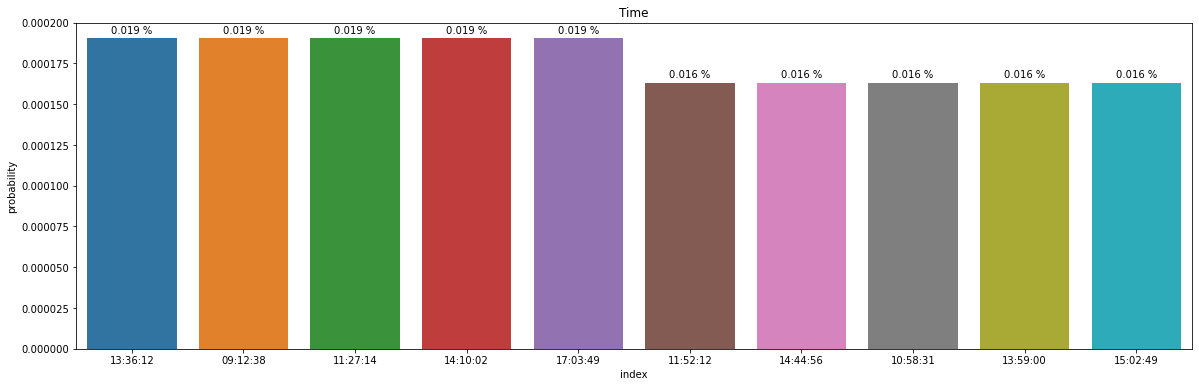

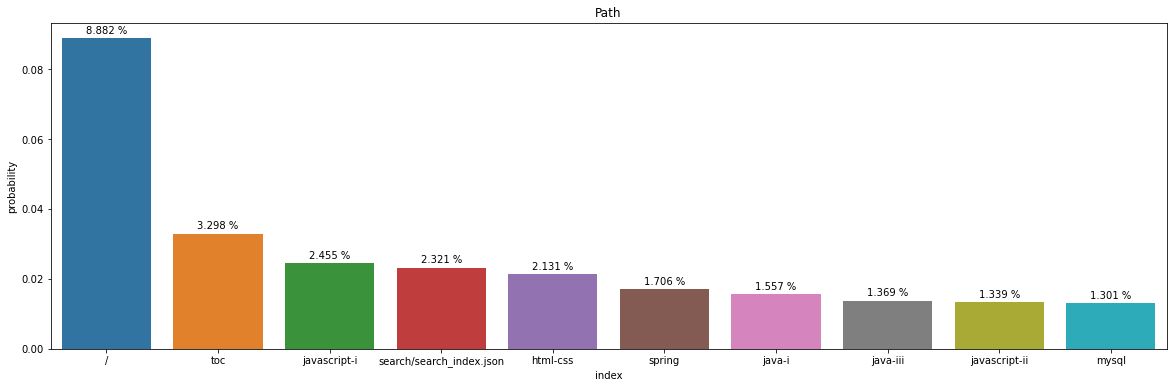

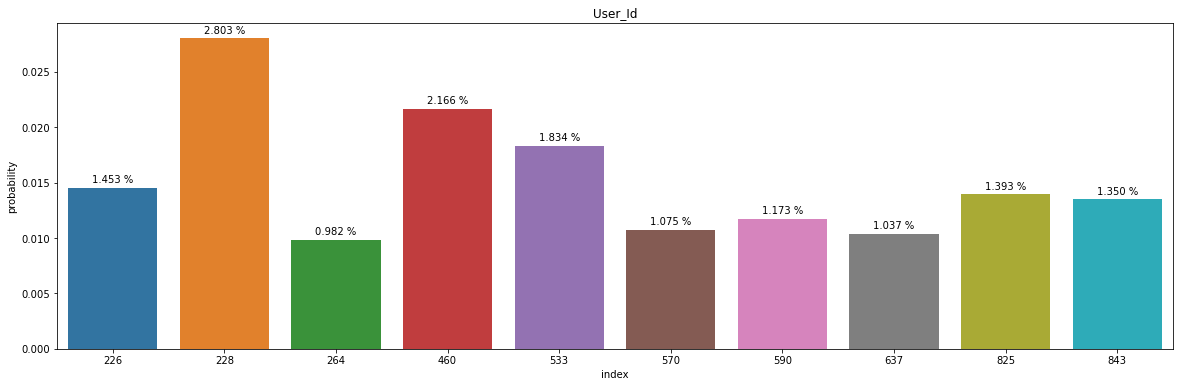

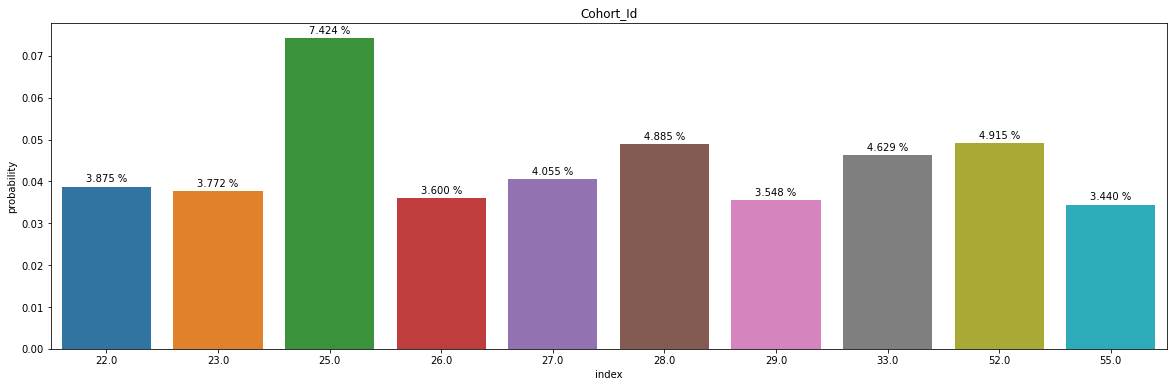

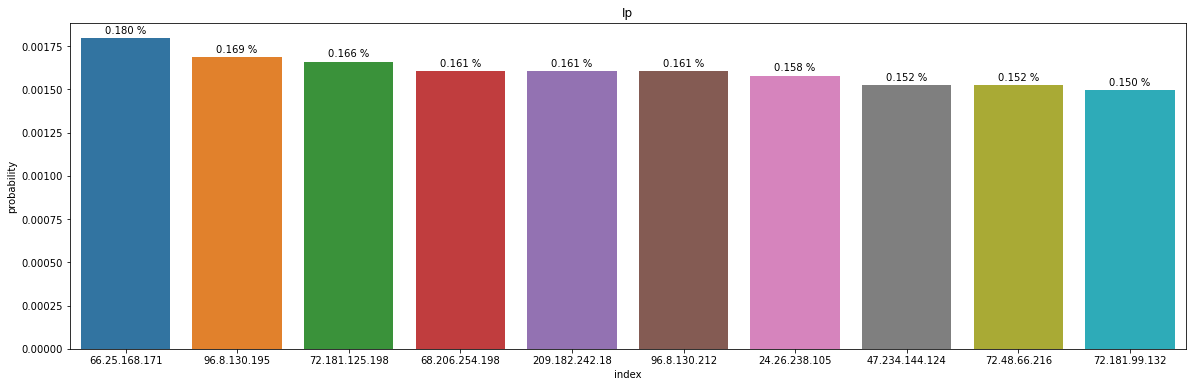

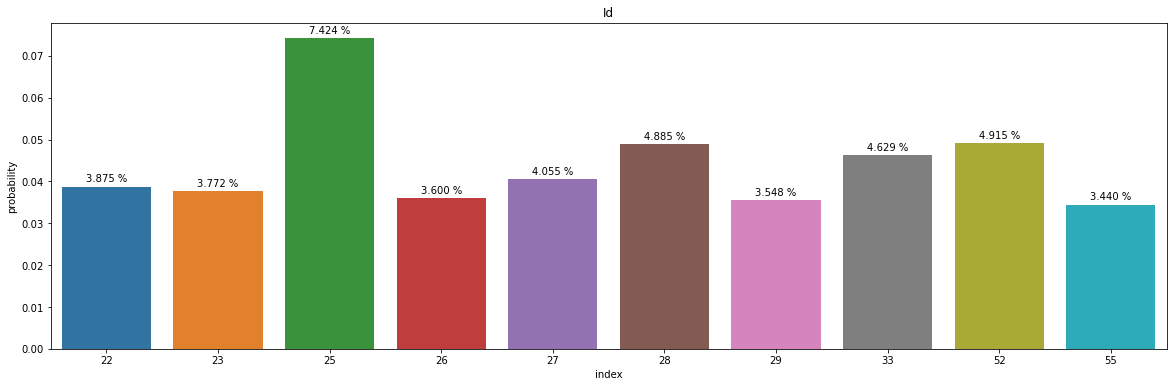

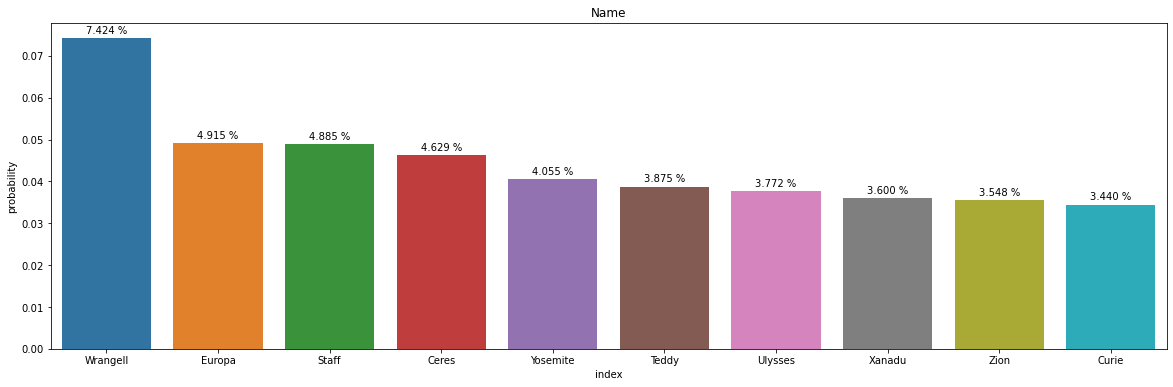

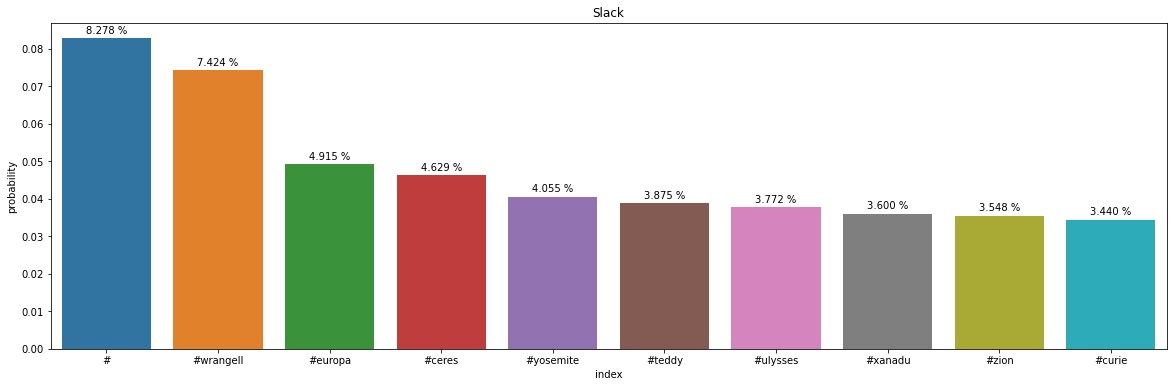

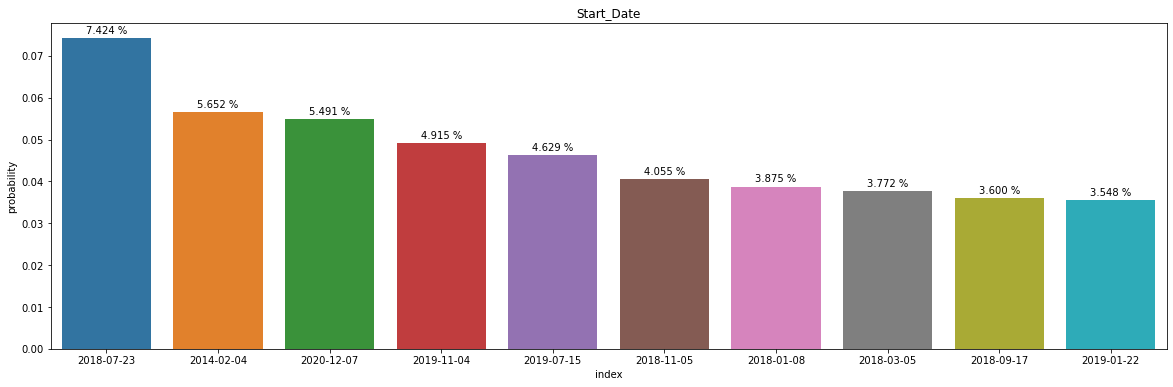

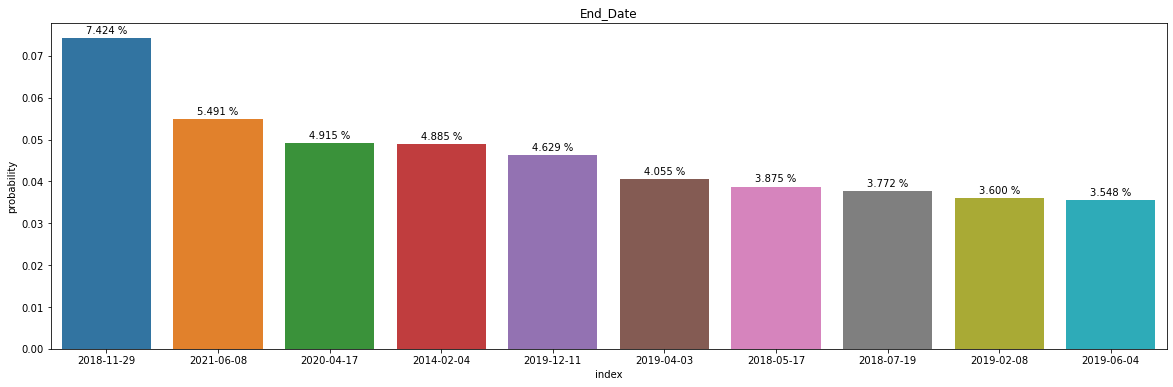

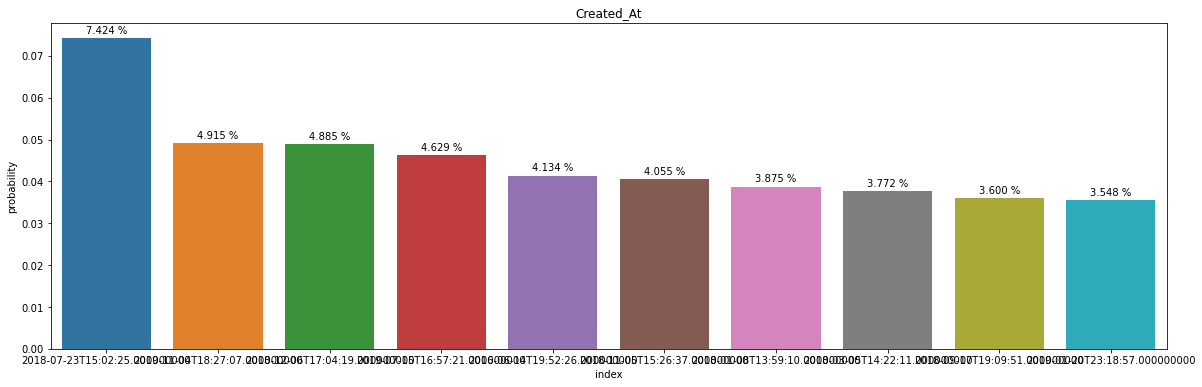

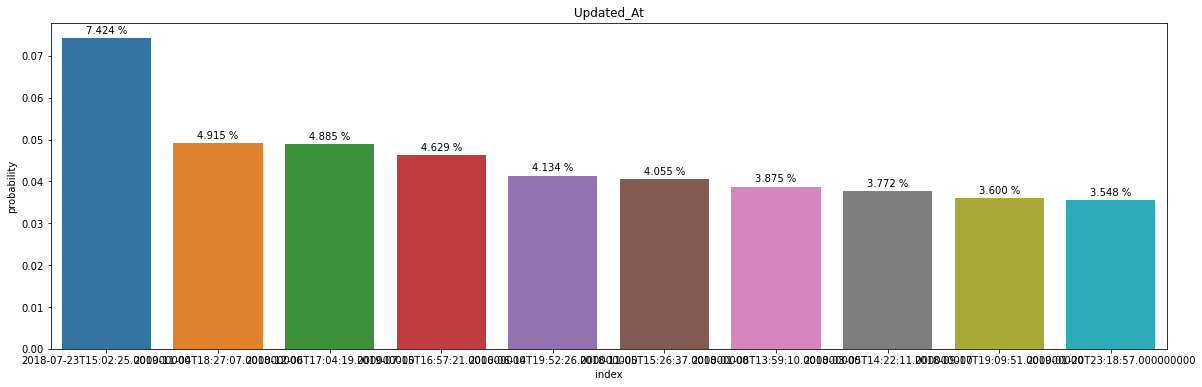

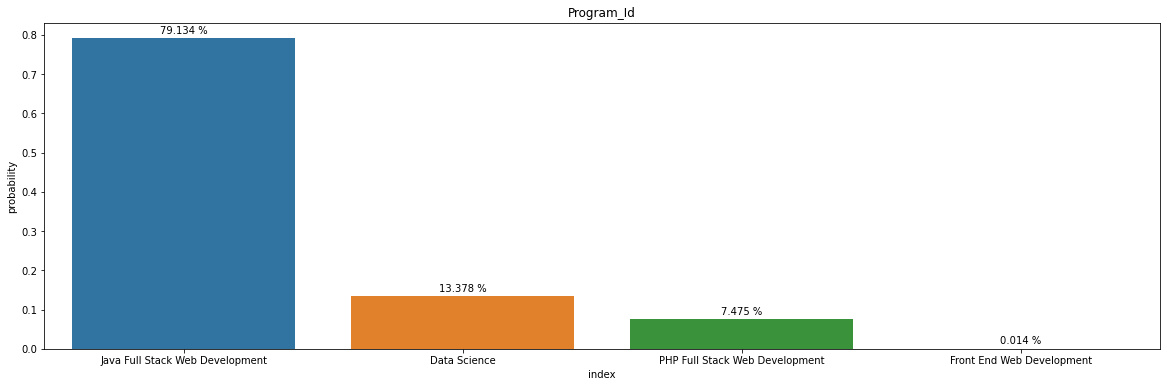

In [217]:
# Isolate ip_addresses
ip_df = pd.crosstab(index=df.ip,
           columns=df.path)
# Drop the column path '/'
ip_df = ip_df.drop(columns=['/'])
ip_df['sum'] = ip_df.sum(axis=1)
# Filter for students who have between 10 and 50 path requests
ip_df = ip_df[(ip_df['sum'] > 1) & (ip_df['sum'] < 50)]
# Sort by sum
ip_df_sorted = ip_df.sort_values(by='sum')
# Find the lowest_ip's and put them to a list to sort by later
lowest_ip_list = ip_df_sorted.index.to_list()

plotProb(df[df.ip.isin(lowest_ip_list)])

## Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

In [380]:
# Start by resampling by hour to look at how many path requests are coming in from each ip address
hourly_path_req_df = df.groupby(['date', 'hour', 'ip']).agg({'path': 'count'}).sort_values(by='path', ascending=False)
hourly_path_req_df = hourly_path_req_df[hourly_path_req_df.path > 100].sort_index()
tmp = hourly_path_req_df.index.to_frame()
print('These are the unique ip addresses that have path requests more than 100 per hour at some point and time:\n')
print(*tmp.ip.unique())

These are the unique ip addresses that have path requests more than 100 per hour at some point and time:

97.105.19.61 108.65.244.91 97.105.19.58 192.171.117.210 173.173.121.126 204.44.112.76 72.177.174.24 67.10.166.10 70.117.31.136 172.124.70.146 72.128.136.219 172.124.67.93 104.238.45.6 104.190.242.24 70.125.137.220 71.150.217.33 70.130.123.81


## What topics are grads continuing to reference after graduation and into their jobs (for each program)?

In [384]:
# end_date is going to be the key feature for this, but first they need to be datetime objs
df.end_date = pd.to_datetime(df.end_date)

In [388]:
grad_df = df[df.index > df.end_date]

def find_answers_per_cohort(df):
    cohort_and_lesson = pd.crosstab(index=df.path,
               columns=df.name)
    cohort_and_lesson['sum'] = cohort_and_lesson.sum(axis=1)
    return cohort_and_lesson.sort_values(by='sum', ascending=False).head(20).index.to_list()

for program in df.program_id.unique():
    print(f'Program {program}:')
    print(find_answers_per_cohort(grad_df[grad_df.program_id == program]), end='\n\n')

Program PHP Full Stack Web Development:
['/', 'index.html', 'javascript-i', 'html-css', 'spring', 'java-iii', 'java-ii', 'java-i', 'javascript-ii', 'appendix', 'jquery', 'mysql', 'content/html-css', 'javascript-i/introduction/working-with-data-types-operators-and-variables', 'java-iii/servlets', 'javascript-i/javascript-with-html', 'spring/fundamentals/views', 'java-iii/jsp-and-jstl', 'javascript-i/functions', 'spring/fundamentals/repositories']

Program Java Full Stack Web Development:
['/', 'javascript-i', 'spring', 'search/search_index.json', 'html-css', 'java-iii', 'java-ii', 'java-i', 'appendix', 'javascript-ii', 'toc', 'mysql', 'jquery', 'spring/fundamentals/repositories', 'spring/fundamentals/controllers', 'spring/fundamentals/views', 'spring/setup', 'jquery/ajax/weather-map', 'java-iii/servlets', 'html-css/elements']

Program Front End Web Development:
['content/html-css', '/', 'content/html-css/gitbook/images/favicon.ico', 'content/html-css/introduction.html']

Program Data Sc